In [1]:
#*****************************************************************************************************
# Fix settings concerning the ansatz, optimisation and backend
#*****************************************************************************************************

from time import time 
import pickle 
import numpy as np

from discopy import Ty, Id, Box, Diagram, Word
from discopy.rigid import Cup, Cap, Functor, Swap
from discopy.quantum.circuit import bit, qubit
from discopy.quantum import Measure
from discopy.quantum.tk import to_tk
from discopy.quantum.tk import Circuit as tk_Circuit_inDCP

from qiskit import IBMQ
from pytket.extensions.qiskit import (AerBackend,IBMQBackend,IBMQEmulatorBackend,)
from pytket import Circuit as tk_Circuit

#-----------------------------
# atomic pregroup grammar types
#-----------------------------
s, n = Ty('S'), Ty('N')

#----------------------------------------
# settings concerning the ansaetze
#----------------------------------------
q_s = 1        # number of qubits for sentence type s
q_n = 1        # number of qubits for noun type n
depth = 1      # number of IQP layers for non-single-qubit words
p_n = 3        # number of parameters for a single-qubit word (noun); valued in {1,2,3}.

#----------------------------------------
# Parameters concerning the optimisation
#----------------------------------------
n_runs = 1      # number of runs over training procedure
niter  = 100 #100    # number of iterations for any optimisation run of training.

#----------------------------------------
# Parameters for quantum computation
#----------------------------------------
max_n_shots = 2 ** 13  # maximum shots possible

#---------------------
# Fix the backend
#---------------------
backend = AerBackend()  # this is a noise free quantum simulation that will be carried out on your computer
                        # and which does not rely on an IBMQ account.

# Alternatively: 
# ***************      !!! Note: Insert here your IBMQ account token !!!
# provider = IBMQ.enable_account(<INSERT_IBM_QUANTUM_EXPERIENCE_TOKEN>)

# backend = IBMQEmulatorBackend(<backend_name>, <credentials>)
#or
# backend = IBMQBackend(<backend_name>, <credentials>)
print('check')

check


In [2]:
#******************************************
# Data import
#******************************************

# import train, dev and test datasets: the data entries are all strings of the form 'label sentence' 
# with the label in {0,1} and with the sentence of the form "word1_POStag1 word2_POStag2 ..."
import os
print(os.path.isfile('./adapted data/new_datasets/train_data.txt'))


with open('./adapted data/new_datasets/train_data.txt') as f:
    training_data_raw = f.readlines()

with open('./adapted data/new_datasets/dev_data.txt') as f:
    dev_data_raw = f.readlines()

with open('./adapted data/new_datasets/test_data.txt') as f:
    testing_data_raw = f.readlines()
    
print('test')


True
test


In [3]:
#***************************************************************
# Turn the raw input data into data structures convenient below
#***************************************************************

vocab = dict()          # dictionary to be filled with the vocabulary in the form { word : POStag }
data = dict()           # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
training_data = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data = []       # list of sentences in the test dataset as strings "word1 word2 ..."

# Go through the train data
for sent in training_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    training_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

# Go through the dev data
for sent in dev_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    dev_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label
    
# Go through the test data
for sent in testing_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    testing_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label
print(testing_data)
print('check')

['injection improved dizziness', 'injection introduced severe dizziness', 'injection caused severe chestpain', 'ibuprofen introduced burning musclepain', 'ibuprofen caused dizziness', 'ibuprofen caused bloating', 'injection worsened bloating', 'injection solved dizziness', 'injection improved bloating', 'injection improved chestpain', 'aspirin improved musclepain', 'aspirin solved musclepain', 'aspirin introduced burning dizziness', 'aspirin introduced burning bloating', 'aspirin introduced throbbing chestpain', 'ibuprofen improved severe chestpain', 'ibuprofen improved musclepain', 'ibuprofen improved burning musclepain']
check


In [4]:
#*****************************************************
# The sentences as diagrams via context free gramamr (CFG) production rules
#*****************************************************

#----------------------------
# Further part-of-speech (POS) tags:
#----------------------------
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

#----------------------------
# The vocabulary in DisCoPy
#----------------------------
vocab_dict_boxes = dict()
for word, tag in vocab.items():
    if tag == 'N':
        vocab_dict_boxes.update({word: Word(word, n)})
    if tag == 'TV':
        vocab_dict_boxes.update({word: Word(word, tv)})
    if tag == 'ADJ':
        vocab_dict_boxes.update({word: Word(word, adj)})

#-------------------------------------
# The CFG production rules as boxes
#-------------------------------------
r0 = Box('R0', nphr @ vphr, s)
r1 = Box('R1', tv @ nphr, vphr)
r2 = Box('R2', adj @ n, nphr)
r3 = Box('R3', iv, vphr)
r4 = Box('R4', n, nphr)

#---------------------------------------------
# The needed grammatical sentence structures
#---------------------------------------------
grammar_dict = {
    'N_TV_N': ((Id(n @ tv) @ r4) >> (r4 @ r1) >> r0),
    'N_TV_ADJ_N': ((Id(n @ tv) @ r2) >> (r4 @ r1) >> r0),
    'ADJ_N_TV_N': ((Id(adj @ n @ tv) @ r4) >> (r2 @ r1) >> r0),
    'ADJ_N_TV_ADJ_N': ((Id(adj @ n @ tv) @ r2) >> (r2 @ r1) >> r0)
}

#---------------------------------------------
# Create CFG diagrams for the sentences
#---------------------------------------------
sentences_dict = dict()
for sentstr in list(data.keys()):
    grammar_id = ''
    sentence = Id(Ty())
    for word in sentstr.split(' '):
        grammar_id += (vocab[word] + '_')
        sentence = sentence @ vocab_dict_boxes[word]
    grammar_id = grammar_id[:-1]
    sentence = sentence >> grammar_dict[grammar_id]
    sentences_dict.update({sentstr: [sentence, grammar_id]})
print('check')

check


In [5]:
#***************************************************************
# Translation to pregroup grammar 
#***************************************************************
from discopy.grammar.pregroup import draw

# From POS tags to Pregroup types:
ob_pg = {n: n, s: s, adj: n @ n.l, tv: n.r @ s @ n.l, vphr:  n.r @ s, nphr: n}

# From CFG rules to Pregroup reductions: 
ar_pg = {
    r0: Cup(n, n.r) @ Id(s),
    r1: Id(n.r @ s) @ Cup(n.l, n),
    r2: Id(n) @ Cup(n.l, n),
    r3: Id(n.r @ s),
    r4: Id(n)
}

# The vocabulary as DisCoPy boxes with pregroup types
vocab_pg = [Word(vocab_dict_boxes[word].name, ob_pg[vocab_dict_boxes[word].cod]) for word in vocab.keys()]

# The mapping of morphisms
ar_pg.update({vocab_dict_boxes[word]: Word(vocab_dict_boxes[word].name, ob_pg[vocab_dict_boxes[word].cod]) for word in vocab.keys()})

# The functor that translates from CFG to pregroup
t2p = Functor(ob_pg, ar_pg)

sentences_pg_dict = dict()
for sentstr in sentences_dict:
    sentences_pg_dict.update({sentstr: [t2p(sentences_dict[sentstr][0]), sentences_dict[sentstr][1]]})
print('check')

check


In [6]:
#******************************************************************************************************
# (Optional) For visualisation: the sentences as pregroup diagrams -- before 'bending nouns around'
#******************************************************************************************************
"""
for sentstr in sentences_pg_dict:
    sentences_pg_dict[sentstr][0].draw()
print('check')
"""

"\nfor sentstr in sentences_pg_dict:\n    sentences_pg_dict[sentstr][0].draw()\nprint('check')\n"

In [7]:
#******************************************************
# Bending the nouns around
#******************************************************
sentences_pg_psr_dict = dict()

for sentstr in sentences_pg_dict:
    grammar_id = sentences_pg_dict[sentstr][1]
    num_words = len(grammar_id.split('_'))
    words = sentences_pg_dict[sentstr][0][:num_words].boxes
    grammar = sentences_pg_dict[sentstr][0][num_words:]
    if grammar_id == 'N_TV_N':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
    if grammar_id == 'ADJ_N_TV_N':
        noun1 = Box(words[1].name, n.l, Ty())
        noun2 = Box(words[3].name, n.l, Ty())
        words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
    if grammar_id == 'N_TV_ADJ_N':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[3].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
    if grammar_id == 'ADJ_N_TV_ADJ_N':
        noun1 = Box(words[1].name, n.l, Ty())
        noun2 = Box(words[4].name, n.l, Ty())
        words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ words[3] @ Id(n) @ noun2)
    # add newly wired sentence to dictionary
    sentence = words_new >> grammar
    # Yank snakes and add to dictionary
    sentences_pg_psr_dict.update({sentstr: sentence.normal_form()})

# Now for the vocab
vocab_psr = []
for word in vocab_pg:
    if word.cod == Ty('N'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)
print('check')

check


In [8]:
#******************************************************************************************************
# (Optional) For visualisation: the sentences as pregroup diagrams -- after 'bending nouns around'
#******************************************************************************************************
"""
for sentstr in sentences_pg_psr_dict:
    sentences_pg_psr_dict[sentstr].draw()
print('check')
"""

"\nfor sentstr in sentences_pg_psr_dict:\n    sentences_pg_psr_dict[sentstr].draw()\nprint('check')\n"

In [9]:
#*****************************************************
# Translation to quantum circuits
#*****************************************************
from discopy.quantum import Ket, IQPansatz, Bra
from discopy.quantum.gates import sqrt, H, CZ, Rz, Rx, CX
from discopy.quantum import CircuitFunctor, Id
from discopy.quantum import Circuit as DCP_Circuit

ob = {s: q_s, n: q_n}                           # assignment of number of qubits to atomic grammatical types
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   # the form in which it is needed for discopy's cqmap module

#-----------------------------------------
# parametrised part of ansaetze
#-----------------------------------------

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)       

def ansatz_state(state, params):  
    arity = sum(ob[Ty(factor.name)] for factor in state.cod)
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    else:
        return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params):  
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    else:
        return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

#----------------------------------------------------------
# Define parametrised functor to quantum circuits
#----------------------------------------------------------
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})  # send the effect with n.l to same quantum effect
    return CircuitFunctor(ob_cqmap, ar)
print('check')

check


In [10]:
#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

"""
def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.zeros(par_shapes[i]))))
    return params 
"""

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i]))))
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped
print('check')

check


In [11]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     34


In [12]:
#**************************************************************
# (Optional) Quantum circuit diagrams for the sentences 
#**************************************************************
#print(len(rand_shaped_pars))
"""
func = F(rand_shaped_pars)

for sentstr in sentences_pg_psr_dict:
    func(sentences_pg_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5))
print('check')
"""

"\nfunc = F(rand_shaped_pars)\n\nfor sentstr in sentences_pg_psr_dict:\n    func(sentences_pg_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5))\nprint('check')\n"

In [13]:
#**************************************************************
# (Optional) Quantum circuit diagrams for the sentences 
#**************************************************************
"""
from pytket.extensions.qiskit import tk_to_qiskit

for sentstr in sentences_pg_psr_dict:

    circuit = func(sentences_pg_psr_dict[sentstr])
    tk_circ = circuit.to_tk()
    print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
    print("post selection:\n{}\n".format(tk_circ.post_selection))
    print("scalar:\n{}\n".format(tk_circ.scalar))
    print("qiskit circuit:")
    tk_to_qiskit(tk_circ).draw()
print('check')
"""

'\nfrom pytket.extensions.qiskit import tk_to_qiskit\n\nfor sentstr in sentences_pg_psr_dict:\n\n    circuit = func(sentences_pg_psr_dict[sentstr])\n    tk_circ = circuit.to_tk()\n    print("{}:\n{}\n".format(tk_circ, \'\n\'.join(map(str, tk_circ))))\n    print("post selection:\n{}\n".format(tk_circ.post_selection))\n    print("scalar:\n{}\n".format(tk_circ.scalar))\n    print("qiskit circuit:")\n    tk_to_qiskit(tk_circ).draw()\nprint(\'check\')\n'

In [14]:
#********************************************************************************************
# Encode data such that the circuits (for one call of cost function etc.) can be sent as one
# job to quantum hardware.
#********************************************************************************************

train_labels = []
train_circuits_pg_psr = []
for sentstr in training_data:
    train_circuits_pg_psr.append(sentences_pg_psr_dict[sentstr])
    train_labels.append(np.array(data[sentstr]))
train_labels = np.array(train_labels)

dev_labels = []
dev_circuits_pg_psr = []
for sentstr in dev_data:
    dev_circuits_pg_psr.append(sentences_pg_psr_dict[sentstr])
    dev_labels.append(np.array(data[sentstr]))
dev_labels = np.array(dev_labels)

test_labels = []
test_circuits_pg_psr = []
for sentstr in testing_data:
    test_circuits_pg_psr.append(sentences_pg_psr_dict[sentstr])
    test_labels.append(np.array(data[sentstr]))
test_labels = np.array(test_labels)
print('check')

check


In [15]:
#**********************************************************************************
# Split cost and error functions for time efficiency
#**********************************************************************************

def get_probs(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    train_circuits = [(func(circ) >> Measure()) for circ in train_circuits_pg_psr]
    results = DCP_Circuit.eval(*train_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res / np.sum(res) for res in results_tweaked]
    return pred_labels_distrs

def get_cost(pred_labels_distrs):
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    return -1 / len(training_data) * np.sum(cross_entropies)

def get_train_error(pred_labels_distrs):
    error = 0.0
    assert len(pred_labels_distrs[0]) == 2  # rounding only makes sense if labels are binary tuples
    pred_labels = [np.round(res) for res in pred_labels_distrs]
    for i in range(len(pred_labels)):
        if np.sum(pred_labels[i]) != 1.0:  # when equal weights or no counts gives label [1,1] (due to - 1e-9)
            error += 1
        else:
            error += np.abs(train_labels[i][0] - pred_labels[i][0]) # above ensures precited label as [0,1] or [1,0]
    return round(error * 100 / len(training_data), 1)

def get_dev_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    dev_circuits = [(func(circ) >> Measure()) for circ in dev_circuits_pg_psr]
    results = DCP_Circuit.eval(*dev_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    assert len(results_tweaked[0]) == 2
    pred_labels = [np.round(res / np.sum(res)) for res in results_tweaked]
    error = 0.0
    for i in range(len(pred_labels)):
        if np.sum(pred_labels[i]) != 1.0:
            error += 1
        else:
            error += np.abs(dev_labels[i][0] - pred_labels[i][0])
    error = round(error * 100 / len(dev_data), 1)
    return error, pred_labels

def get_test_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    test_circuits = [(func(circ) >> Measure()) for circ in test_circuits_pg_psr]
    results = DCP_Circuit.eval(*test_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    assert len(results_tweaked[0]) == 2
    pred_labels = [np.round(res / np.sum(res)) for res in results_tweaked]
    error = 0.0
    for i in range(len(pred_labels)):
        if np.sum(pred_labels[i]) != 1.0:
            error += 1
        else:
            error += np.abs(test_labels[i][0] - pred_labels[i][0])
    error = round(error * 100 / len(testing_data), 1)
    return error, pred_labels
print('check')

check


In [16]:
#**********************************************************************************
# Minimization algorithm
#**********************************************************************************

# This is building on the minimizeSPSA function from the noisyopt package (https://github.com/andim/noisyopt);
# here only adjusted for our purposes. As this is an example notebook for a final run of the experiment
# the dev set is not used here.

def my_spsa(get_probs, get_cost, get_train_error, get_test_error, x0,
            bounds=None, niter=100, a=10.0, c=10.0, alpha=0.602, gamma=0.101,
            print_iter=False, correct_func_value=True,
            filename='spsa_output', iters_selected=[]):
    A = 0.01 * niter
    N = len(x0)
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    param_history = []
    func_history = []
    error_history = []
    pred_label_history = []
    pred_labels_test_error = dict()
    test_error_list = []
    x = x0    
    
    # Loop over iterations
    for k in range(niter):
        if print_iter:
            print('-------------', '\n', 'iteration: ', k, sep='')
        start = time()
        
        # determine stepping parameters
        ak = a/(k+1.0+A)**alpha
        ck = c/(k+1.0)**gamma
        delta = np.random.choice([-1, 1], size=N)
        
        # move in + direction from previous x
        xplus = project(x + ck*delta)        
        if print_iter:
            print('Call for xplus')
        results_tweaked_plus = get_probs(xplus)
        funcplus = get_cost(results_tweaked_plus)
        
        # move in - direction from previous x
        xminus = project(x - ck*delta)
        if print_iter:
            print('Call for xminus')
        results_tweaked_minus = get_probs(xminus)
        funcminus = get_cost(results_tweaked_minus)
        
        # new step
        grad = (funcplus - funcminus) / (xplus-xminus)
        x = project(x - ak*grad)
        param_history.append(x)
        
        # determine current func and error
        if correct_func_value or k == (niter - 1):  # In order to save time the cost at x is only evaluated for final step
            if print_iter:
                print('Call for current_func_value')
            results_tweaked = get_probs(x)
            current_func_value = get_cost(results_tweaked)
            error = get_train_error(results_tweaked)
            pred_label_history.append(results_tweaked)
        else:
            current_func_value = funcplus
            error = get_train_error(results_tweaked_plus)
            pred_label_history.append(results_tweaked_plus)
        
        # calculate test error if a 'selected iteration' 
        if k in iters_selected:
            print('Calculate test error for iteration:', k)
            res = get_test_error(x)
            test_error_list.append(res[0])
            pred_labels_test_error.update({k: res[1]})
        
        func_history.append(current_func_value)
        error_history.append(error)

        # save to file
        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history,
            'predlabel_history': pred_label_history,
            'iters_selected': iters_selected,
            'test_error_list': test_error_list,
            'pred_labels_test_error': pred_labels_test_error
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        if print_iter:
            print('Time taken for this iteration: ', time() - start)
    print(param_history)
    return param_history, func_history, error_history, test_error_list
print('check')

check


In [17]:
#**********************************************************************************
# Minimization algorithm
#**********************************************************************************
def my_psr(get_probs, get_cost, get_train_error, get_test_error, x0,
            bounds=None, niter=100, a=0.3, c=0.1, alpha=1, gamma=1/8,
            print_iter=False, correct_func_value=True,
            filename='spsa_output', iters_selected=[]):
    A = 0.01 * niter
    N = len(x0)
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    param_history = []
    func_history = []
    error_history = []
    pred_label_history = []
    pred_labels_test_error = dict()
    test_error_list = []
    x = x0    
    
    order = np.arange(N)

    # Loop over iterations
    for k in range(niter):
        if print_iter:
            print('-------------', '\n', 'iteration: ', k, sep='')
        start = time()
        
        i = k%N
        j = k//N
        if i ==0:
            np.random.shuffle(order)
            
        # determine stepping parameters
        ak = a/(2*j+1.0+A)**alpha
        ck = c/(j+1.0)**gamma
        delta_plus = np.zeros(N)
        delta_minus = np.zeros(N)
        delta_plus[order[i]] += 1/4
        delta_minus[order[i]] -= 1/4
        
        # move in + direction from previous x
        xplus = project(x + delta_plus)        
        if print_iter:
            print('Call for xplus')
        results_tweaked_plus = get_probs(xplus)
        funcplus = get_cost(results_tweaked_plus)
        
        # move in - direction from previous x
        xminus = project(x + delta_minus)
        if print_iter:
            print('Call for xminus')
        results_tweaked_minus = get_probs(xminus)
        funcminus = get_cost(results_tweaked_minus)
        
        # new step
        grad = (funcplus - funcminus)*np.pi
        x[order[i]]-= ak*grad
        x = project(x)
        print(x)
        print(ak*grad)
        param_history.append(x)
        
        # determine current func and error
        if correct_func_value or k == (niter - 1):  # In order to save time the cost at x is only evaluated for final step
            if print_iter:
                print('Call for current_func_value')
            results_tweaked = get_probs(x)
            current_func_value = get_cost(results_tweaked)
            error = get_train_error(results_tweaked)
            print(error)
            pred_label_history.append(results_tweaked)
        else:
            current_func_value = funcplus
            error = get_train_error(results_tweaked_plus)
            pred_label_history.append(results_tweaked_plus)
        
        # calculate test error if a 'selected iteration' 
        if k in iters_selected:
            print('Calculate test error for iteration:', k)
            res = get_test_error(x)
            test_error_list.append(res[0])
            pred_labels_test_error.update({k: res[1]})
        
        func_history.append(current_func_value)
        error_history.append(error)

        # save to file
        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history,
            'predlabel_history': pred_label_history,
            'iters_selected': iters_selected,
            'test_error_list': test_error_list,
            'pred_labels_test_error': pred_labels_test_error
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        if print_iter:
            print('Time taken for this iteration: ', time() - start)
    return param_history, func_history, error_history, test_error_list
print('check')

check


In [18]:
#************************************
# Quantum run: training and error calculation
#************************************

bounds = [[0.0, 1.0] for ii in range(len(rand_unshaped_pars))]
c_fix = 0.1   
a_est = 0.3

param_histories = []
cost_histories = np.zeros((n_runs, niter))
error_train_histories = np.zeros((n_runs, niter))

# For test error calculation (for reasons of time cost not for all iterations)
iters_selected = [(i+1)*10-1 for i in range(int(niter/10))]
iters_selected.insert(0, 0)
error_test_histories = np.zeros((n_runs, len(iters_selected)))

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = randparams(par_shapes)
    start = time()
    res = my_psr(get_probs, get_cost, get_train_error, get_test_error, rand_unshaped_pars,
                  bounds=bounds, niter=niter, a=a_est, c=c_fix,
                  print_iter=True, correct_func_value=False, filename=('MC_task_SPSAOutput_Run' + str(i)),
                  iters_selected=iters_selected)
    param_histories.append(res[0])   
    cost_histories[i, :] = res[1]
    error_train_histories[i, :] = res[2]
    error_test_histories[i, :] = res[3]
    print('run', i+1, 'done')
    print('Time taken: ', time() - start)
print('check')
print(res[0])

---------------------------------
Start run  1
-------------
iteration: 0
Call for xplus
Call for xminus
[0.27899232 0.80134859 0.37329467 ... 0.36547074 0.32063943 0.09800282]
0.03717023602013234
Calculate test error for iteration: 0
Time taken for this iteration:  9.697264194488525
-------------
iteration: 1
Call for xplus
Call for xminus
[0.27899232 0.80134859 0.37329467 ... 0.36547074 0.32063943 0.09800282]
0.1150126270454337
Time taken for this iteration:  8.011758089065552
-------------
iteration: 2
Call for xplus
Call for xminus
[0.27899232 0.80134859 0.37329467 ... 0.36547074 0.32063943 0.09800282]
0.028720989203120863
Time taken for this iteration:  7.739444017410278
-------------
iteration: 3
Call for xplus
Call for xminus
[0.27899232 0.80134859 0.37329467 ... 0.36547074 0.32063943 0.09800282]
0.06327346308529481
Time taken for this iteration:  7.224055767059326
-------------
iteration: 4
Call for xplus
Call for xminus
[0.27899232 0.80134859 0.37329467 ... 0.45172046 0.320639

Time taken for this iteration:  9.032134294509888
-------------
iteration: 40
Call for xplus
Call for xminus
[0.2713649  0.80134859 0.39678782 ... 0.51760876 0.12448722 0.10953911]
-0.06588829954086899
Time taken for this iteration:  16.24388289451599
-------------
iteration: 41
Call for xplus
Call for xminus
[0.2713649  0.80134859 0.39678782 ... 0.51760876 0.12448722 0.10953911]
-0.030624810868460164
Time taken for this iteration:  7.4653401374816895
-------------
iteration: 42
Call for xplus
Call for xminus
[0.2713649  0.80134859 0.39678782 ... 0.51760876 0.12448722 0.10953911]
0.02724739226311532
Time taken for this iteration:  7.557634115219116
-------------
iteration: 43
Call for xplus
Call for xminus
[0.2713649  0.80134859 0.39678782 ... 0.51760876 0.12448722 0.10953911]
0.002637936751626207
Time taken for this iteration:  17.095449686050415
-------------
iteration: 44
Call for xplus
Call for xminus
[0.2713649  0.80134859 0.39678782 ... 0.51760876 0.12448722 0.10953911]
0.0253637

Time taken for this iteration:  13.04647183418274
-------------
iteration: 80
Call for xplus
Call for xminus
[0.27053686 0.79375613 0.40773732 ... 0.51760876 0.08949775 0.10722657]
0.054742421259009494
Time taken for this iteration:  10.790970802307129
-------------
iteration: 81
Call for xplus
Call for xminus
[0.27053686 0.79375613 0.40773732 ... 0.51760876 0.08949775 0.10722657]
-0.052803760868886836
Time taken for this iteration:  46.8096718788147
-------------
iteration: 82
Call for xplus
Call for xminus
[0.27053686 0.79375613 0.40773732 ... 0.51760876 0.08949775 0.10722657]
0.060638317797450256
Time taken for this iteration:  10.705488204956055
-------------
iteration: 83
Call for xplus
Call for xminus
[0.27053686 0.79375613 0.40773732 ... 0.51760876 0.08949775 0.10722657]
-0.01509478940402034
Time taken for this iteration:  9.4685800075531
-------------
iteration: 84
Call for xplus
Call for xminus
[0.27053686 0.79375613 0.40773732 ... 0.51760876 0.08949775 0.10722657]
-0.01236716

In [19]:
#****************************************************
# Averaging
#****************************************************

# In case N_runs > 1, one may want to calculate cost and errors averaged over several runs...

# In this example notebook however not done, hence:
cost_history = cost_histories[0, :]
error_train_history = error_train_histories[0, :]
error_test_history = error_test_histories[0, :]
print('check')

check


[ 0  1  2 ... 97 98 99] [1.80967126 1.92533025 1.82298747 ... 1.45902668 1.20573931 1.20718691]
[ 0  1  2 ... 97 98 99] [51.7 53.4 46.6 ... 20.7 20.7 19. ]
[0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99] [55.6 50.  33.3 38.9 38.9 16.7 22.2 44.4 33.3 27.8 38.9]


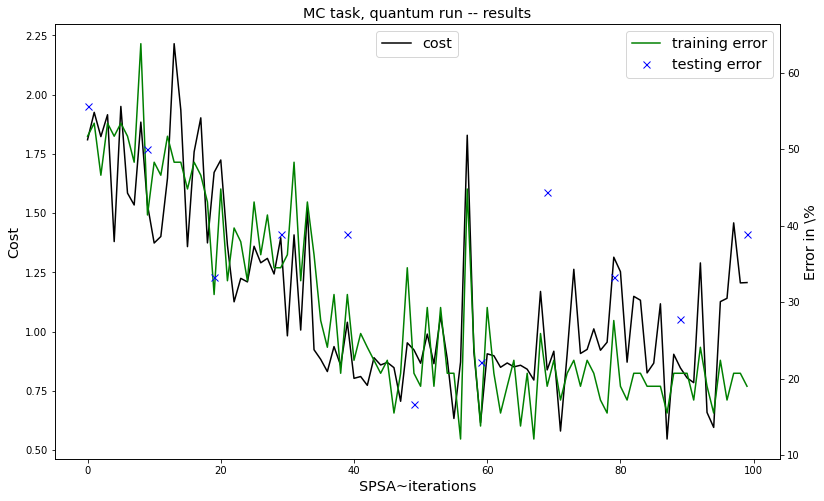

check


In [20]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

#plt.rcParams.update({"text.usetex": True})
fig, ax1 = plt.subplots(figsize=(13, 8))

print(np.arange(len(cost_history)), cost_history)
ax1.plot(np.arange(len(cost_history)), cost_history, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

print(np.arange(len(cost_history)), error_train_history)
print(iters_selected, error_test_history)
ax2 = ax1.twinx()
ax2.set_ylabel("Error in \%", fontsize='x-large')
ax2.plot(np.arange(len(cost_history)), error_train_history, '-g', markersize=4, label='training error')
ax2.plot(iters_selected, error_test_history, 'xb', markersize=7, label='testing error')
ax2.legend(loc='upper right', fontsize='x-large')

plt.title('MC task, quantum run -- results', fontsize='x-large')
plt.savefig('MC_task_Results.png', dpi=300, facecolor='white')  
plt.show()
print('check')

In [21]:
with open('MC_task_SPSAOutput_Run0.pickle', 'rb') as f:
    results = pickle.load(f)
print(results['param_history'][-1])
params = results['param_history'][-1]
params = np.expand_dims(params, 1)
print(params.shape)

#check out test set
error, pred_labels = get_test_error(params)
for i in range(0, 10): 
    print(testing_data[i])
    if (pred_labels[i][0] == 0. ):
        print('not AD')
    else:
        print('AD')
    print('######################################################')



[0.26879757 0.79053805 0.40773732 ... 0.53985464 0.08949775 0.11573549]
(34, 1)
injection improved dizziness
AD
######################################################
injection introduced severe dizziness
AD
######################################################
injection caused severe chestpain
AD
######################################################
ibuprofen introduced burning musclepain
AD
######################################################
ibuprofen caused dizziness
AD
######################################################
ibuprofen caused bloating
AD
######################################################
injection worsened bloating
AD
######################################################
injection solved dizziness
AD
######################################################
injection improved bloating
not AD
######################################################
injection improved chestpain
not AD
######################################################


In [22]:
from discopy.quantum import Circuit

with open('MC_task_SPSAOutput_Run0.pickle', 'rb') as f:
    results = pickle.load(f)
print(results['param_history'][-1])
params = results['param_history'][-1]
params = np.expand_dims(params, 1)
print(params.shape)
#print(results.keys())
#print(results['param_history'])

#print(len(vocab_psr))

par_shapes = paramshapes(vocab_psr)
shaped_pars = reshape_params(params, par_shapes)


def evaluate(params, sentences, backend, n_shots=2**10, seed=0):
    for sentstr in sentences_pg_psr_dict:
        circuits = func(sentences_pg_psr_dict[sentstr])
        results = [Circuit.eval(
                    circuit,
                    backend=backend,
                    n_shots=n_shots,
                    seed=seed,
                    compilation=backend.default_compilation_pass(2)) for circuit in circuits]
        tensors = [np.abs(result.array)[0] for result in results]
    return tensors

delta = .01

[0.26879757 0.79053805 0.40773732 ... 0.53985464 0.08949775 0.11573549]
(34, 1)


In [23]:
np.random.choice([-1, 1], size=10)

array([-1, -1,  1,  1,  1, -1, -1,  1,  1, -1])

In [24]:
a = np.arange(34)
np.random.shuffle(a)
a

array([ 7,  0, 12, ..., 11,  4, 23])